In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Veri setini yükleyip train-test olarak bölmek

In [2]:
data = pd.read_csv("data.csv")
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
y = data["diagnosis"]
X = data.drop(["Unnamed: 32", "diagnosis"], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# Baseline model (Random Forest Classifier)

In [5]:
pipeline = Pipeline([
    #('scaler', StandardScaler()),        RFC için scaler şart değil
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42
    ))
])

In [6]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier(random_state=42))])

In [7]:
y_pred = pipeline.predict(X_test)

In [8]:
acc = accuracy_score(y_test, y_pred)
acc

0.956140350877193

In [9]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores.mean()

np.float64(0.9578481602235678)

In [10]:
cv_scores

array([0.92982456, 0.93859649, 0.98245614, 0.96491228, 0.97345133])

# Feature'ların önemleri (Feature importance)

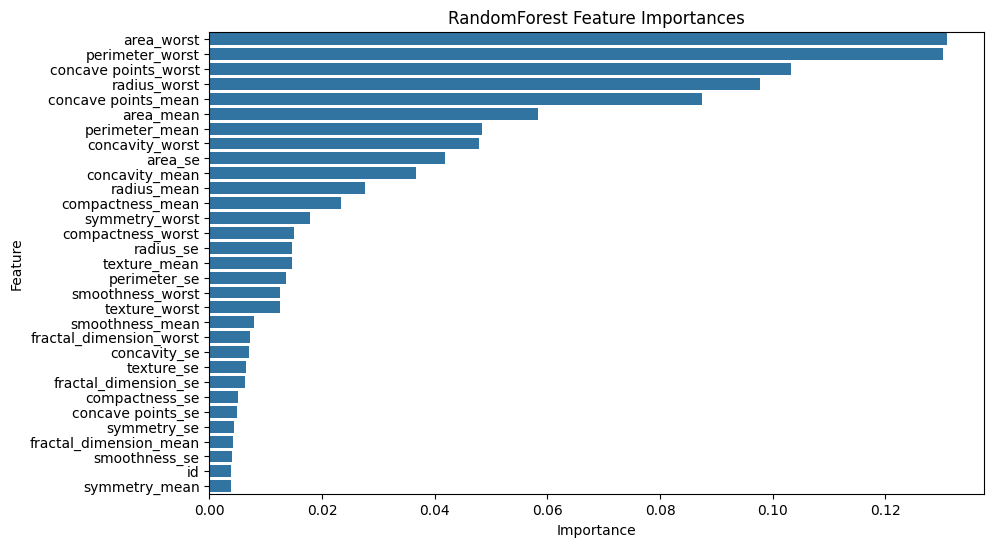

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


importances = pipeline.named_steps['rf'].feature_importances_
features = X.columns


fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title("RandomForest Feature Importances")
plt.show()


# Confusion matrix ile baseline modelin değerlendirilmesi

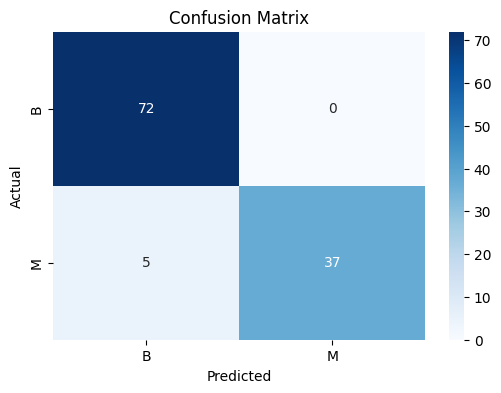

              precision    recall  f1-score   support

           B       0.94      1.00      0.97        72
           M       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['B', 'M'],
            yticklabels=['B', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['B','M']))


# Hiperparametrelerin Tune edilmesi - RandomizedSearchCV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [None, 5, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,            # kaç kombinasyon
    scoring='accuracy',
    cv=5,                 # 5-fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

y_pred = random_search.best_estimator_.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': None, 'rf__max_depth': 20}
Best CV score: 0.9604395604395606
Test Accuracy: 0.9736842105263158


# Optimize edilmiş modelin performansı

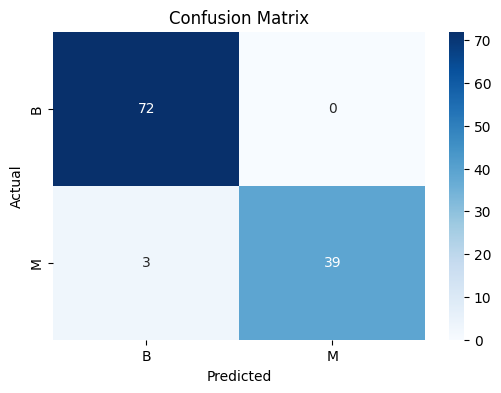

              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['B', 'M'],
            yticklabels=['B', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['B','M']))